# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 02

**Author 1 (sciper):** Basile Spaenlehauer (272570)

**Author 2 (sciper):** Victor Herrmann (284552)

**Author 3 (sciper):** Abed Alrahman Shabaan (237731)

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [59]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

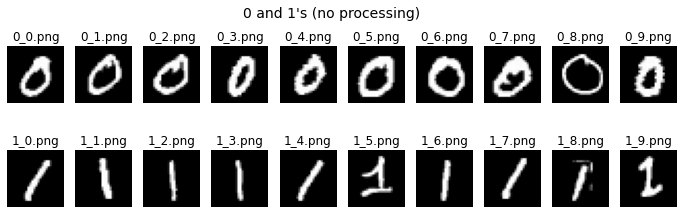

In [60]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names


def plot_imgs(imgs, names, title=None):
    nb_digits = len(imgs)
    nb_imgs = imgs[0].shape[0]
    # Plot images
    fig, axes = plt.subplots(nb_digits, nb_imgs, figsize=(12, 3.5))
    for l_axis, l_imgs, l_names in zip(axes, imgs, names):
        for ax, im, nm in zip(l_axis, l_imgs, l_names):
            ax.imshow(im, cmap='gray')
            ax.axis('off')
            ax.set_title(nm)
    if title:
        fig.suptitle(title, fontsize=14)
#     plt.tight_layout()
    plt.show()

#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

plot_imgs([zeros_im, ones_im], [zeros_names, ones_names], "0 and 1's (no processing)")

# juste pour garder mais on peut le supprimer si vous voulez

# Plot images
# fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
# for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
#     ax.imshow(im, cmap='gray')
#     ax.axis('off')
#     ax.set_title(nm)
# for ax, im, nm in zip(axes[1], ones_im, ones_names):
#     ax.imshow(im, cmap='gray')
#     ax.axis('off')
#     ax.set_title(nm)


We will take a look at the histogram of the images :

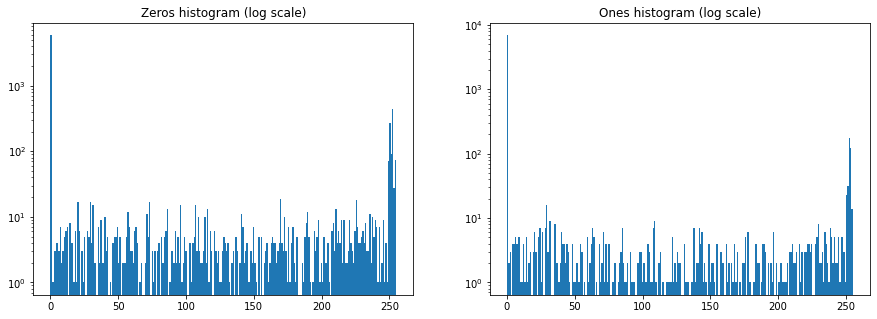

In [61]:
# Plot images
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].hist(zeros_im.flatten(), bins=256)
axes[0].set_title("Zeros histogram (log scale)")
axes[0].set_yscale('log')
axes[1].hist(ones_im.flatten(), bins=256)
axes[1].set_title("Ones histogram (log scale)")
axes[1].set_yscale('log')
plt.show()

We see that the images are mostly black and white pixels so we will apply a threshold to binarize them

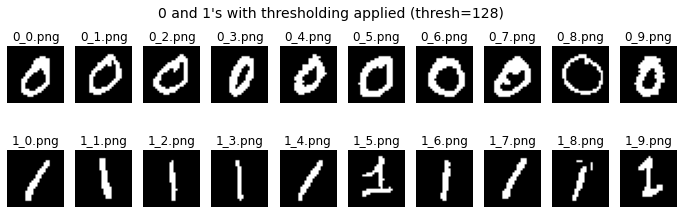

In [62]:
def threshold_images(img, threshold=128):
    r_img = img.copy()
    mask = img>threshold
    r_img[mask] = 1
    r_img[~mask] = 0
    return r_img

zeros_bin = threshold_images(zeros_im, 128)
ones_bin = threshold_images(ones_im, 128)

plot_imgs([zeros_bin, ones_bin], [zeros_names, ones_names], "0 and 1's with thresholding applied (thresh=128)")

Let's see the contours

In [63]:
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import binary_opening
from skimage.feature import canny
from scipy.signal import resample


We will find the contours of the digits based on separation between black an white values.
We use the `find_contours` function for this.

The contours are displayed in red. We see that some present artifacts that are detected with additional contours, we will take care of this in the future.

In [135]:
def plot_imgs_with_contours(imgs, imgs_names, thresh=128):
    num_digits = len(imgs)
    fig, axes = plt.subplots(num_digits, len(zeros_im), figsize=(15, 4))
    for im_axes, img, names in zip(axes, imgs, imgs_names):
        for ax, im, nm in zip(im_axes, img, names):
            ax.imshow(im, cmap='gray')
            for cont in sorted(find_contours(im, thresh), key=lambda x: x.shape[0], reverse=True):
                ax.plot(cont[:,1], cont[:,0], linewidth=3)
            ax.axis('off')
            ax.set_title(nm)
    plt.tight_layout()
    plt.show()

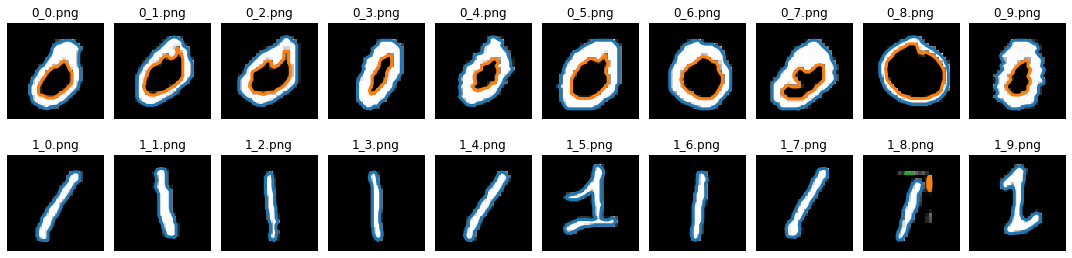

In [136]:
plot_imgs_with_contours([zeros_im, ones_im], [zeros_names, ones_names])

In [130]:
# TO BE REMOVED !!

# fig, axes = plt.subplots(2, len(zeros_im), figsize=(15, 4))
# for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
#     ax.imshow(im, cmap='gray')
#     for cont in sorted(find_contours(im, 128), key=lambda x: x.shape[0], reverse=True):
#         ax.plot(cont[:,1], cont[:,0], linewidth=3)
#     ax.axis('off')
#     ax.set_title(nm)
# for ax, im, nm in zip(axes[1], ones_im, ones_names):
#     ax.imshow(im, cmap='gray')
#     for cont in sorted(find_contours(im, 128), key=lambda x: x.shape[0], reverse=True):
#         ax.plot(cont[:,1], cont[:,0], linewidth=2.5)
#     ax.axis('off')
#     ax.set_title(nm)
# plt.tight_layout()
# plt.show()


We can see that the zeros have two distinct contours, we will concatenate them to form a unique contour as is shown in the image below. therefore we have a line crossing a part of the zero. Also image `1_8.png` seams to have two smaller contours that we want to remove based on their length.

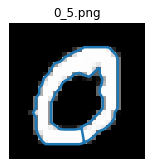

In [65]:
idx = 5
test_im, test_name = zeros_im[idx], zeros_names[idx]

plt.figure(figsize=(2.5, 2.5))
plt.imshow(test_im, cmap='gray')
cont_im = np.concatenate(find_contours(test_im, 128))
plt.plot(cont_im[:,1], cont_im[:,0], linewidth=2.5)
plt.title(test_name)
# plt.gca().invert_yaxis()
plt.axis('equal')
plt.axis('off')
plt.show()

### 1.2 Fourier descriptors (15 pts)

In [66]:
def compute_fourrier_descriptors(im_list, level=128, nb_points = 500):
    # find the contours
    edges = [find_contours(image, level=level) for image in im_list]

    # new container for the contours
    contours = np.empty((im_list.shape[0], nb_points, 2))

    for i, contour_set in enumerate(edges): # contour_set will be a list of all the separate contours
        max_len = sum([len(cont) for cont in contour_set])
        contour = np.concatenate([cont for cont in contour_set if len(cont) > 0.2*max_len])  # filter small contours 
        contours[i] = resample(contour, nb_points)

    edges_cpx = []
    for i in range(len(contours)):
        edges_cpx.append(contours[i][:,0] + 1j*contours[i][:,1])

    # compute the fourier descriptors of the contours
    fourier = [np.abs(np.fft.fft(edge)) for edge in edges_cpx]
    return fourier

After having calculated the Fourier descriptors, we can now proceed to plot the first two components.

In [132]:
# LEGACY
def plot_fourier_disc(zero_fourier_disc, one_fourier_disc):

    x_0 = [zero_fourier_disc[i][2]/zero_fourier_disc[i][1] for i in range (len(zero_fourier_disc))]
    y_0 = [zero_fourier_disc[i][3]/zero_fourier_disc[i][1] for i in range (len(zero_fourier_disc))]

    x_1 = [one_fourier_disc[i][2]/zero_fourier_disc[i][1] for i in range (len(one_fourier_disc))]
    y_1 = [one_fourier_disc[i][3]/zero_fourier_disc[i][1] for i in range (len(one_fourier_disc))]

    plt.scatter(x_0, y_0, label='0')
    plt.scatter(x_1, y_1, label='1')

    plt.legend()
    plt.title('First two normalized components of the fourier descriptors')
    plt.xlabel('f2/f1')
    plt.ylabel('f3/f1')


In [120]:
def plot_fourier_descriptors(digits, title=None, ax=None, annotate=False):
    if ax:
        plt_or_ax = ax
    else:
        plt_or_ax = plt
    for num, digit in enumerate(digits):
        x = [digit[i][2]/digit[i][1] for i in range(len(digit))]
        y = [digit[i][3]/digit[i][1] for i in range(len(digit))]
        plt_or_ax.scatter(x, y, label=str(num))
        if annotate:
            for i in range(len(digit)):
                plt_or_ax.annotate(str(i), (x[i], y[i]))

    if title:
        if ax:
            ax.set_title(title)
        else:
            plt.title(title)
    plt_or_ax.legend()
    if ax:
        ax.set_xlabel('f2/f1')
        ax.set_ylabel('f3/f1')
    else:
        plt.xlabel('f2/f1')
        plt.ylabel('f3/f1')
        plt.show()


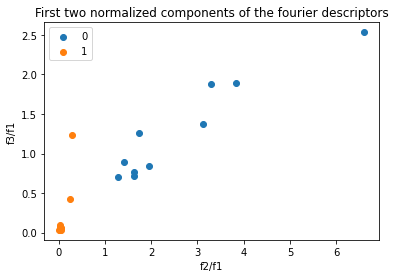

In [122]:

zeros_fourier = compute_fourrier_descriptors(zeros_im, level=128)
ones_fourier = compute_fourrier_descriptors(ones_im, level=128)
# plot_fourier_disc(zeros_fourier, ones_fourier)
# plt.show()
plot_fourier_descriptors([zeros_fourier, ones_fourier], 
                         'First two normalized components of the fourier descriptors',
                         annotate=False)

We can see that the two numbers are linearly separable in this space, and so we can classify them using a simple logistic regression.

We rotate the images and check if the transform is rotation invariant, it should be the case since we only consider the amplitude of the Fourier descriptors

In [112]:
from skimage.transform import  rotate, rescale

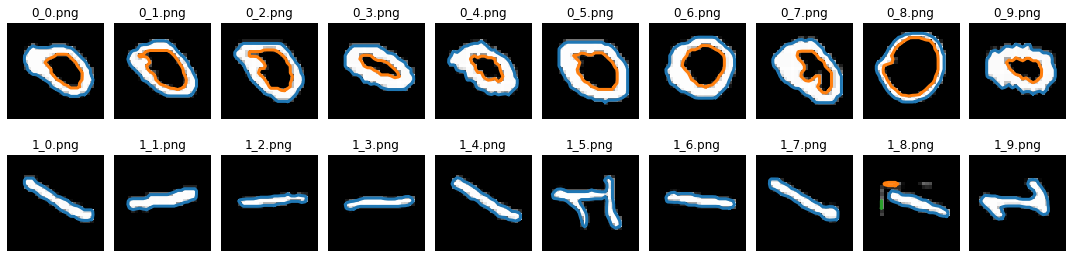

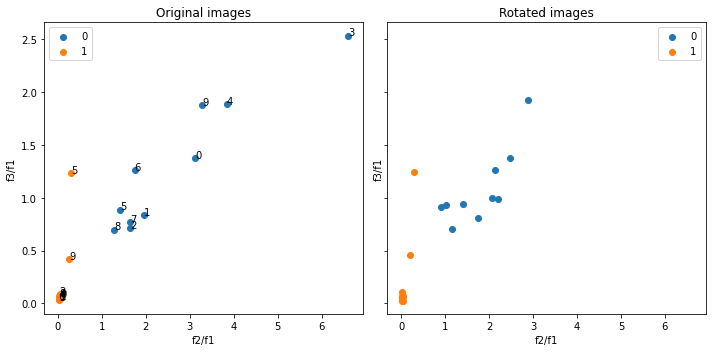

In [133]:
#zeros_rotated = np.array([rotate(zero, angle=90, preserve_range=True).astype(np.uint8) for zero in zeros_im])
#ones_rotated = np.array([rotate(one, angle=90, preserve_range=True).astype(np.uint8) for one in ones_im])

zeros_rotated = np.array([zero.T[::-1,:] for zero in zeros_im])
ones_rotated = np.array([one.T[::-1,:] for one in ones_im])

plot_imgs_with_contours([zeros_rotated, ones_rotated], [zeros_names, ones_names])
# fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
# for ax, im, nm in zip(axes[0], zeros_rotated, zeros_names):
#     ax.imshow(im, cmap='gray')
#     #contour_im  = np.concatenate(find_contours(im, 128))
#     #ax.plot(contour_im[:,1], contour_im[:,0], linewidth=2, c='r')
#     for cont in find_contours(im, 128):
#         ax.plot(cont[:,1], cont[:,0], linewidth=2, c='r')
#     ax.axis('off')
#     ax.set_title(nm)
# for ax, im, nm in zip(axes[1], ones_rotated, ones_names):
#     ax.imshow(im, cmap='gray')
#     #contour_im  = np.concatenate(find_contours(im, 128))
#     #ax.plot(contour_im[:,1], contour_im[:,0], linewidth=2, c='r')
#     for cont in find_contours(im, 128):
#         ax.plot(cont[:,1], cont[:,0], linewidth=2, c='r')
#     ax.axis('off')
#     ax.set_title(nm)
# plt.show()


fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
plot_fourier_descriptors([zeros_fourier, ones_fourier], 'Original images', ax=ax[0], annotate=True)

zeros_rotated_fourier = compute_fourrier_descriptors(zeros_rotated)
ones_rotated_fourier = compute_fourrier_descriptors(ones_rotated)
plot_fourier_descriptors([zeros_rotated_fourier, ones_rotated_fourier], 'Rotated images', ax=ax[1])
plt.tight_layout()
plt.show()


We see that the images remain clearly separable, although we see some slight differneces in the representations. We think
those are due to numerical errors in the calculation.

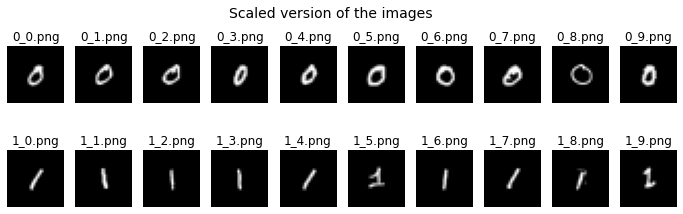

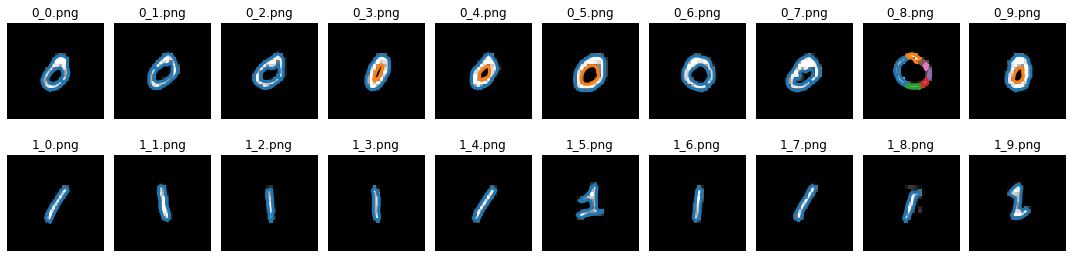

In [137]:

zeros_scaled = np.array([np.pad(zero,pad_width=zero.shape[0]//2) for zero in zeros_im])
ones_scaled = np.array([np.pad(one,pad_width=one.shape[0]//2) for one in ones_im])

zeros_scaled = np.array([rescale(zero, scale=0.5, preserve_range=True).astype(np.uint8) for zero in zeros_scaled])
ones_scaled = np.array([rescale(one, scale=0.5, preserve_range=True).astype(np.uint8) for one in ones_scaled])

#zeros_scaled = zeros_im[:,::2,::2]
#ones_scaled = ones_im

plot_imgs([zeros_scaled, ones_scaled], [zeros_names, ones_names], 'Scaled version of the images')
plot_imgs_with_contours([zeros_scaled, ones_scaled], [zeros_names, ones_names], thresh=100)

The scaling done, let's see how that affects our Fourier descriptors

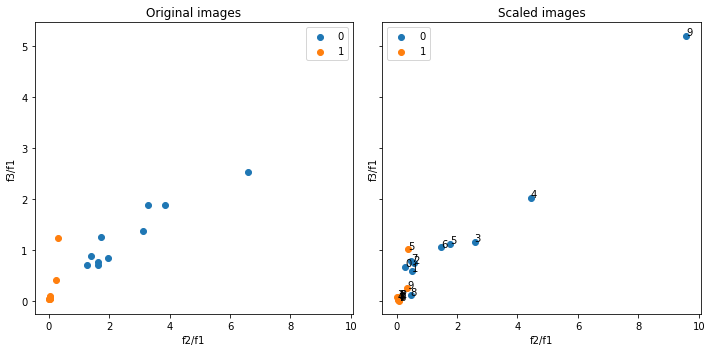

In [156]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
plot_fourier_descriptors([zeros_fourier, ones_fourier], 'Original images', ax=ax[0])

zeros_fourier_scaled = compute_fourrier_descriptors(zeros_scaled, level=100)
ones_fourier_scaled = compute_fourrier_descriptors(ones_scaled, level=100)
plot_fourier_descriptors([zeros_fourier_scaled, ones_fourier_scaled], 'Scaled images', ax=ax[1], annotate=True)
plt.tight_layout()
plt.show()


### 1.3 Additional method (5 pts)

We compare our input image to a circle and a straight line, and choose the distance between the image and each of those as features.

To do so, we calculate a distance map for the circle and the line images.

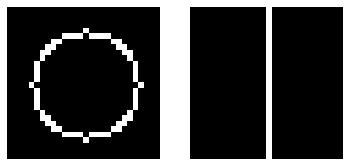

In [159]:
# Add your implementation and discussion
outer_circle = np.pad(skimage.morphology.selem.disk(10), (4,4), constant_values=0)[:-1,:-1]
inner_circle = np.pad(skimage.morphology.selem.disk(9), pad_width=(5,5), constant_values=0)[:-1,:-1]
circle = outer_circle - inner_circle
line = np.zeros((28,28))
line[:,14] = 1
plt.subplot(121)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(line, cmap='gray')
plt.axis('off')
plt.show()

Next we calculate the distance maps for each of these elements.

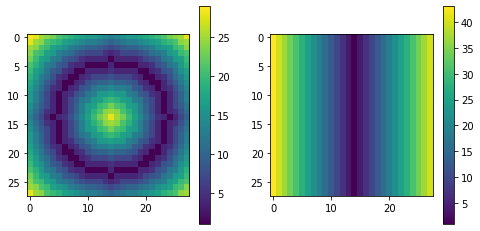

In [167]:
# invert the circle values so that it is 0 on the circle
circle_map = circle.copy()
circle_map[circle==0] = 255
circle_map[circle==255] = 0
# invert the line values so that it is 0 on the line
line_map = line.copy()
line_map[line==0] = 255
line_map[line==255] = 0

# pad the line and circle befre we do the forward so that we have a complete map
line_map = np.pad(line_map, pad_width=1, constant_values=255)
circle_map = np.pad(circle_map, pad_width=1, constant_values=255)

# Forward pass
for i in range(1,circle_map.shape[0]):
    for j in range(1,circle_map.shape[1]-1):
        circle_map[i,j] = min([circle_map[i,j], 
                               3+circle_map[i-1,j], 
                               3+circle_map[i, j-1], 
                               4+circle_map[i-1,j-1], 
                               4+circle_map[i-1,j+1]])
        line_map[i,j] = min([line_map[i,j], 
                             3+line_map[i-1,j], 
                             3+line_map[i, j-1], 
                             4+line_map[i-1,j-1], 
                             4+line_map[i-1,j+1]])

# Back pass
for i in range(circle_map.shape[0]-2,-1,-1):
    for j in range(circle_map.shape[1]-2,0,-1):
        circle_map[i,j] = min([circle_map[i,j], 
                               3+circle_map[i+1,j], 
                               3+circle_map[i, j+1], 
                               4+circle_map[i+1,j-1], 
                               4+circle_map[i+1,j+1]])
        line_map[i,j] = min([line_map[i,j], 
                             3+line_map[i+1,j], 
                             3+line_map[i, j+1], 
                             4+line_map[i+1,j-1], 
                             4+line_map[i+1,j+1]])

# remove the padding
circle_map = circle_map[1:-1, 1:-1]
line_map = line_map[1:-1, 1:-1]

# plot the distance maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
col1 = ax1.imshow(circle_map)
fig.colorbar(col1, ax=ax1)
col2 = ax2.imshow(line_map)
fig.colorbar(col2, ax=ax2)
plt.show()

(10, 2)


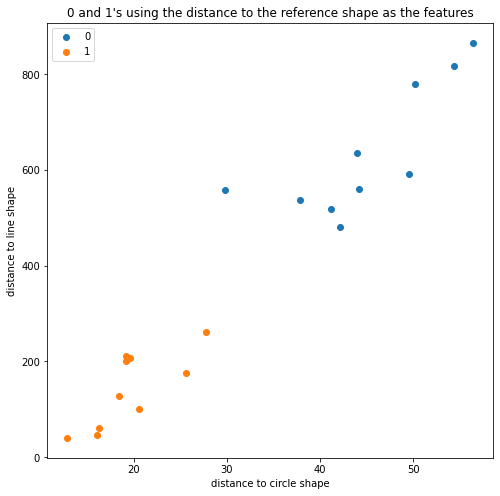

In [176]:
dist_zeros_circle = (zeros_im * circle_map).mean(axis=(1,2))
dist_zeros_bar = (zeros_im * line_map).mean(axis=(1,2))

dist_ones_circle = (ones_im * circle_map).mean(axis=(1,2))
dist_ones_bar = (ones_im * line_map).mean(axis=(1,2))

dist_zeros = np.concatenate([dist_zeros_circle.reshape(-1,1), dist_zeros_bar.reshape(-1,1)], axis=1)
dist_ones = np.concatenate([dist_ones_circle.reshape(-1,1), dist_ones_bar.reshape(-1,1)], axis=1)

print(dist_zeros.shape)

plt.figure(figsize=(8,8))
plt.scatter(dist_zeros[:,0], dist_zeros[:,1], label='0')
plt.scatter(dist_ones[:,0], dist_ones[:,1], label='1')
plt.title("0 and 1's using the distance to the reference shape as the features")
plt.xlabel('distance to circle shape')
plt.ylabel('distance to line shape')
plt.legend()
plt.show()

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

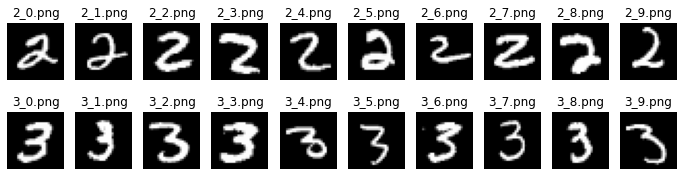

In [139]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

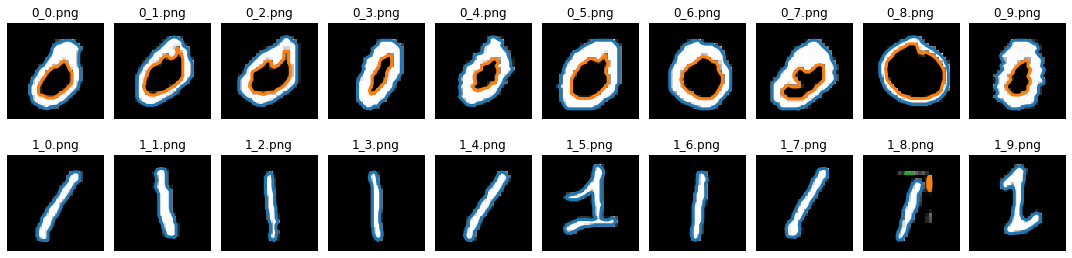

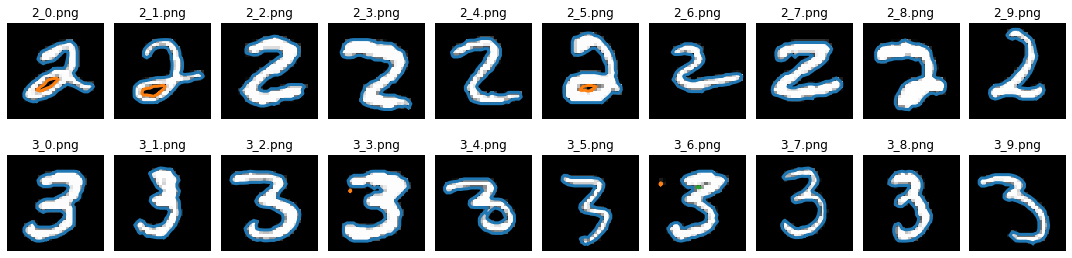

In [154]:
# Add your implementation and discussion
plot_imgs_with_contours([zeros_im, ones_im], [zeros_names, ones_names], thresh=128)
plot_imgs_with_contours([twos_im, threes_im], [twos_names, threes_names], thresh=80)


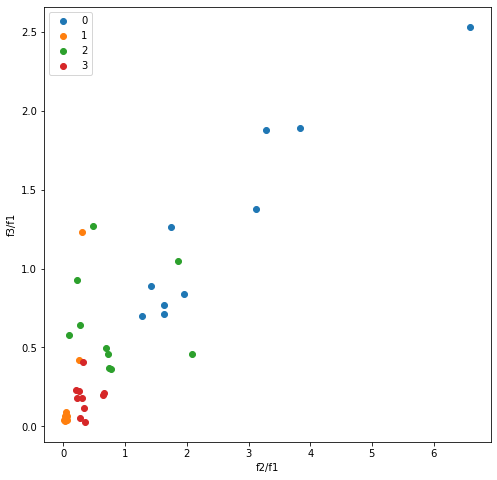

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
zeros_fourier = compute_fourrier_descriptors(zeros_im, level=128)
ones_fourier = compute_fourrier_descriptors(ones_im, level=128)
twos_fourier = compute_fourrier_descriptors(twos_im, level=80)
threes_fourier = compute_fourrier_descriptors(threes_im, level=80)
plot_fourier_descriptors([zeros_fourier, ones_fourier, twos_fourier, threes_fourier])

We see that it is not possible to classify the digits using fourier descriptors.